# New Zealand Time-series Forecasting Model

# Pre-processing and Modeling 

In this notebook we are going to do pre-processing and modeling on our time-series data. We are going to decide what we want to focus on with this modeling. 

We'll start with the tourism arrivals data and then look at the accomodation data. 

We will beging by importing the necessary packages for looking at the data and creating our models.

[1.0 Tourism Data](#1.0-Tourism-Data)

[2.0 Accomodation Data](#2.0-Accomodation-Data)

In [80]:
# Import data processing packages
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.metrics import mean_squared_error

#Time Series Packages
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit

#Modeling packages
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import datetime as dt

#Visualization 
import matplotlib. pyplot as plt
import seaborn as sns

# 1.0 Tourism Data
For our `arrivals` data we are going to look at the following regions as these have the most complete time-series data:
> - Auckland
> - Christchurch
> - Wellington
> - Queenstown
> - All New Zealand Ports
    
For each of these regions, we are going to look at the following reasons for travel:
> - Business
> - Holiday
> - Visiting Friends
> - Total Travel

We want to create the most complete picture that we can for our forecasting and making sure we work on creating as thorough of a forecasting as we can. 

In [81]:
## Load our Tourism Data
# Check how columns are parsed
arrivals = pd.read_csv('../NZ Data/Arrivals Data Cleaned.csv', skipinitialspace = True, parse_dates = True, \
                       index_col = 0)
arrivals.columns

Index(['BusinessAuckland ', 'BusinessChristchurch ', 'BusinessDunedin ',
       'BusinessHamilton ', 'BusinessPalmerston North ', 'BusinessRotorua ',
       'BusinessWellington ', 'BusinessQueenstown ',
       'BusinessTOTAL NEW ZEALAND PORTS', 'Holiday/VacationAuckland ',
       'Holiday/VacationChristchurch ', 'Holiday/VacationDunedin ',
       'Holiday/VacationHamilton ', 'Holiday/VacationPalmerston North ',
       'Holiday/VacationRotorua ', 'Holiday/VacationWellington ',
       'Holiday/VacationQueenstown ',
       'Holiday/VacationTOTAL NEW ZEALAND PORTS',
       'Visit Friends/RelativesAuckland ',
       'Visit Friends/RelativesChristchurch ',
       'Visit Friends/RelativesDunedin ', 'Visit Friends/RelativesHamilton ',
       'Visit Friends/RelativesPalmerston North ',
       'Visit Friends/RelativesRotorua ', 'Visit Friends/RelativesWellington ',
       'Visit Friends/RelativesQueenstown ',
       'Visit Friends/RelativesTOTAL NEW ZEALAND PORTS',
       'TOTAL ALL TRAVEL PURPO

In [82]:
# Remove extra white space at end of column
arrivals.columns = arrivals.columns.str.replace(r' $','', regex = True)
arrivals.columns

Index(['BusinessAuckland', 'BusinessChristchurch', 'BusinessDunedin',
       'BusinessHamilton', 'BusinessPalmerston North', 'BusinessRotorua',
       'BusinessWellington', 'BusinessQueenstown',
       'BusinessTOTAL NEW ZEALAND PORTS', 'Holiday/VacationAuckland',
       'Holiday/VacationChristchurch', 'Holiday/VacationDunedin',
       'Holiday/VacationHamilton', 'Holiday/VacationPalmerston North',
       'Holiday/VacationRotorua', 'Holiday/VacationWellington',
       'Holiday/VacationQueenstown', 'Holiday/VacationTOTAL NEW ZEALAND PORTS',
       'Visit Friends/RelativesAuckland',
       'Visit Friends/RelativesChristchurch', 'Visit Friends/RelativesDunedin',
       'Visit Friends/RelativesHamilton',
       'Visit Friends/RelativesPalmerston North',
       'Visit Friends/RelativesRotorua', 'Visit Friends/RelativesWellington',
       'Visit Friends/RelativesQueenstown',
       'Visit Friends/RelativesTOTAL NEW ZEALAND PORTS',
       'TOTAL ALL TRAVEL PURPOSESAuckland',
       'TOTAL ALL

In [83]:
# Check to make sure index is datetime
arrivals.index

DatetimeIndex(['1978-04-01', '1978-05-01', '1978-06-01', '1978-07-01',
               '1978-08-01', '1978-09-01', '1978-10-01', '1978-11-01',
               '1978-12-01', '1979-01-01',
               ...
               '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01',
               '2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01',
               '2022-04-01', '2022-05-01'],
              dtype='datetime64[ns]', name='Date', length=530, freq=None)

In [84]:
arrivals.head()

,BusinessAuckland,BusinessChristchurch,BusinessDunedin,BusinessHamilton,BusinessPalmerston North,BusinessRotorua,BusinessWellington,BusinessQueenstown,BusinessTOTAL NEW ZEALAND PORTS,Holiday/VacationAuckland,...,Visit Friends/RelativesTOTAL NEW ZEALAND PORTS,TOTAL ALL TRAVEL PURPOSESAuckland,TOTAL ALL TRAVEL PURPOSESChristchurch,TOTAL ALL TRAVEL PURPOSESDunedin,TOTAL ALL TRAVEL PURPOSESHamilton,TOTAL ALL TRAVEL PURPOSESPalmerston North,TOTAL ALL TRAVEL PURPOSESRotorua,TOTAL ALL TRAVEL PURPOSESWellington,TOTAL ALL TRAVEL PURPOSESQueenstown,TOTAL ALL TRAVEL PURPOSESTOTAL NEW ZEALAND PORTS
Date,,,,,,,,,,,,,,,,,,,,,
1978-04-01,3428.0,468.0,0.0,0.0,0.0,0.0,492.0,0.0,4408.0,10476.0,...,3324.0,19856.0,6240.0,0.0,0.0,0.0,0.0,2116.0,0.0,28524.0
1978-05-01,2264.0,524.0,0.0,0.0,0.0,0.0,428.0,0.0,3236.0,7168.0,...,3568.0,15428.0,5240.0,0.0,0.0,0.0,0.0,2156.0,0.0,23060.0
1978-06-01,2136.0,280.0,0.0,0.0,0.0,0.0,384.0,0.0,2880.0,4640.0,...,2600.0,11416.0,2708.0,0.0,0.0,0.0,0.0,1252.0,0.0,15760.0
1978-07-01,2156.0,324.0,0.0,0.0,0.0,0.0,380.0,0.0,2964.0,6184.0,...,3144.0,14072.0,4900.0,0.0,0.0,0.0,0.0,1480.0,0.0,20892.0
1978-08-01,2304.0,536.0,0.0,0.0,0.0,0.0,496.0,0.0,3416.0,8236.0,...,4204.0,17960.0,7900.0,0.0,0.0,0.0,0.0,2748.0,0.0,28992.0


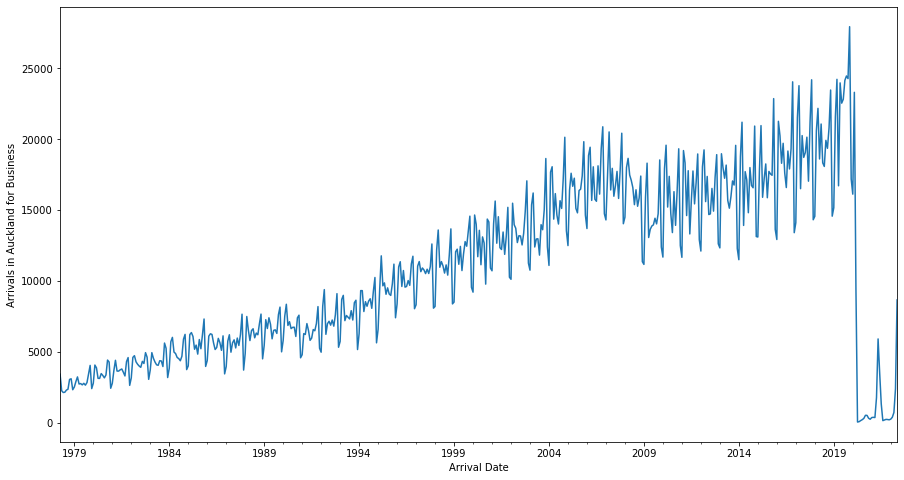

In [85]:
# Lets start with modeling our Auckland data as a test and create a piepeline which will help us speed up the process


arrivals['BusinessAuckland'].plot(figsize = (15,8))
plt.xlabel('Arrival Date')
plt.ylabel('Arrivals in Auckland for Business')
plt.show()

In [86]:
# Lets set our target variable specifically to this data series

y = arrivals[['BusinessAuckland']]

<AxesSubplot:title={'center':'Residual IDs'}, xlabel='Date'>

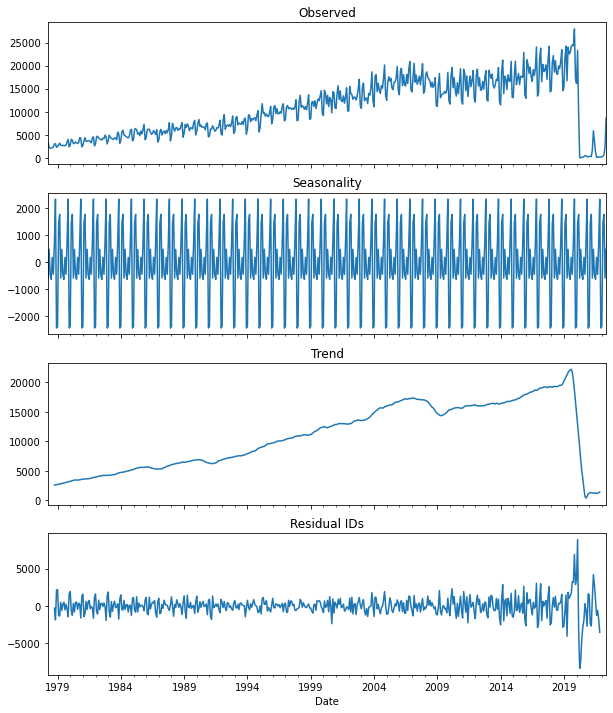

In [87]:
res = seasonal_decompose(y, model='additive')

# Plot the original data, the trend, the seasonality, and the residuals 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,12), sharex=True);

res.observed.plot(ax=ax1, title='Observed')
res.seasonal.plot(ax=ax2, title='Seasonality')
res.trend.plot(ax=ax3, title='Trend')
res.resid.plot(ax=ax4, title='Residual IDs')

In [88]:
# Lets test for stationary with KPSS

from statsmodels.tsa.stattools import kpss
statistic, p_value, n_lags, critical_values = kpss(y, nlags='auto')

print('Statistic: ', statistic)
print('p-value: ', p_value)
print('Number of Lags: ', n_lags)
print('Critical Values: ', critical_values)

Statistic:  2.09166317858846
p-value:  0.01
Number of Lags:  15
Critical Values:  {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\lutim\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [89]:
# Another test for stationarity is the Augmented Dickey-Fuller Test
# This function taken from Jose Portilla's Time Series class

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}\n')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    print() #empty line for formatting
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is STATIONARY")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is NOT STATIONARY")

In [90]:
adf_test(y)

Augmented Dickey-Fuller Test: 

ADF test statistic       -2.124399
p-value                   0.234818
# lags used              19.000000
# observations          510.000000
critical value (1%)      -3.443237
critical value (5%)      -2.867224
critical value (10%)     -2.569797

Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is NOT STATIONARY


In [91]:
y.head()

,BusinessAuckland
Date,
1978-04-01,3428.0
1978-05-01,2264.0
1978-06-01,2136.0
1978-07-01,2156.0
1978-08-01,2304.0


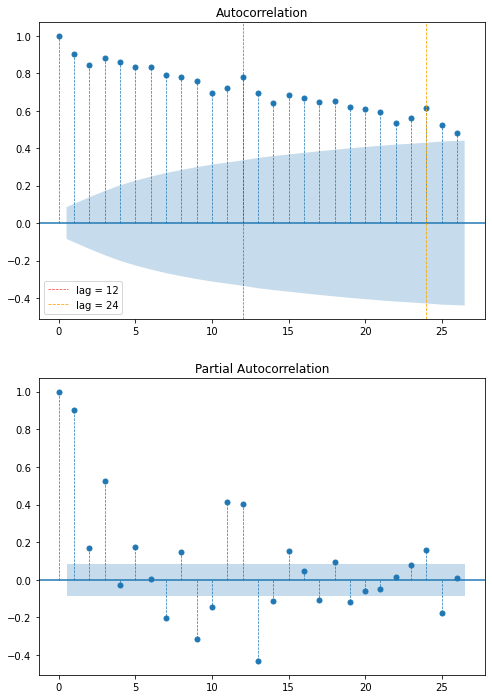

In [92]:
fig, ax = plt.subplots(2, figsize=(8,12))

# plot the ACF
tsaplots.plot_acf(y, ax=ax[0], vlines_kwargs={'ls':'--', 'linewidth': 0.7}, lags=26)

# place marker lines on lags 12 and 24 to highligh the period of seasonality
ax[0].axvline(12, color='red', ls='--', alpha=0.8, lw=0.7, label='lag = 12')
ax[0].axvline(24, color='orange', ls='--', alpha=1, lw=0.8, label='lag = 24')
ax[0].legend()

# plot the PACF
tsaplots.plot_pacf(y, ax=ax[1], vlines_kwargs={'ls':'--', 'linewidth': 0.7}, lags=26)

plt.show()

In [93]:
#take diff to increase stationarity and remove first 12 NaN
ydiff = y.diff(12)
ydiff = ydiff.iloc[12:]

In [98]:
ydiff.index

DatetimeIndex(['1979-04-01', '1979-05-01', '1979-06-01', '1979-07-01',
               '1979-08-01', '1979-09-01', '1979-10-01', '1979-11-01',
               '1979-12-01', '1980-01-01',
               ...
               '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01',
               '2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01',
               '2022-04-01', '2022-05-01'],
              dtype='datetime64[ns]', name='Date', length=518, freq=None)

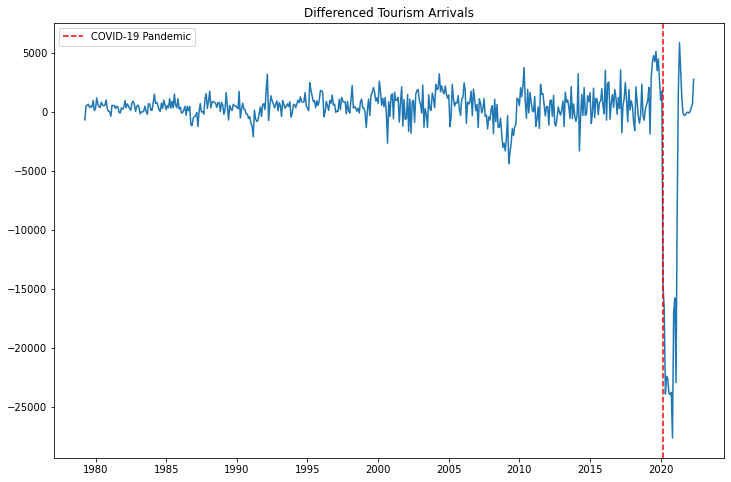

In [102]:
plt.figure(figsize=(12,8))

# plot the differenced data
plt.title('Differenced Tourism Arrivals')
plt.plot(ydiff, lw=1.5)

# add line to indicate pandemic
plt.axvline(pd.Timestamp('2020-03-01'), color='r', ls='--', label='COVID-19 Pandemic')

plt.legend()
plt.show()

We've made our data have stationarity it's possible we may want to consider NOT calculating the difference from 03/01/2020 due to the massive impact that was made by the COVID-19 Pandemic. This may throw off our future forecasting.

In [103]:
statistic, p_value, n_lags, critical_values = kpss(ydiff.iloc[1:], nlags='auto')

print('KPSS Test Statistic: '.ljust(22), statistic)
print('p-value: '.ljust(22), p_value)
print('Number of Lags: '.ljust(22), n_lags)
print('Critical Values: '.ljust(22), critical_values)

KPSS Test Statistic:   0.33431835530408704
p-value:               0.1
Number of Lags:        14
Critical Values:       {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\lutim\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [104]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


from pandas.plotting import autocorrelation_plot

In [105]:
def get_mse(data, order=(0,0,0), seasonal_order=(0,0,0,0)):
    """
    Creates a 'Seasonal AR Integrated Moving Average w/ eXogenous factors'
    ('SARIMAX') model.
    
    Creates a Train-Test split, fits the data, forecasts the data over the 
    validation period, then compares the forecasted data with the actual data
    """
    
    # Train-Test split. Validation is 24 months in prep to forecast 24 months out
    X = data.iloc[:len(data)-24]
    y = data.drop(X.index)
      
    # define and fit the model
    model = SARIMAX(X, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    
    # predict the future!
    pred = model_fit.forecast(len(y))
    
    # return the MSE on our prediction
    return mean_squared_error(y, pred)

In [106]:
# Make a function to evaluate different SARIMAX models with different p, d, and q values.
# As well as different Seasonal p, d, and q values.  It then compares the MSEs
# for all models and returns the model parameters for the lowest Error model.

def get_pdq (data):
    i = 0
    mses = pd.DataFrame()  # holds model parameters and MSEs
    
    # nested loop through all parameters.  this loop could be optimized but
    # is left as-is because it's easier to understand.
    for p in range(0,2):
        for d in range(0,2):
            for q in range (0,3):
                for ps in range(0,2):
                    for ds in range(0,2):
                        for qs in range(0,2):
                            # build/fit/predict model and get the MSE
                            mse = get_mse(data, order=(p,d,q), 
                                          seasonal_order=(ps,ds,qs,12))
                            
                            # save the parameters and MSE
                            mses = mses.append(
                                pd.DataFrame({'p':p, 
                                              'd':d, 
                                              'q':q,
                                              'ps':ps,
                                              'ds':ds,
                                              'qs':qs,
                                              'mse':mse}, index=[i]))
                            i = i+1
             
    # sort our collection by MSE and return the parameters with the lowest MSE
    mses = mses.sort_values(by='mse', axis=0, ascending=True).reset_index()
    return mses.iloc[0]

In [109]:
import warnings
warnings.filterwarnings("ignore")

# Test our get_mse() function
print('MSE: ', get_mse(ydiff, (0,1,1)) ) 

MSE:  293451254.57518864


In [110]:
# Finally, we can find an optimum SARIMAX model for our data.
# Nb. this can take a while...!

# Get the optimal parameters for our model
pdq = get_pdq(ydiff)

print('mse: '.ljust(6), pdq.mse)
print()
print('p:'.ljust(6), int(pdq.p))
print('d:'.ljust(6), int(pdq.d))
print('q:'.ljust(6), int(pdq.q))
print('ps:'.ljust(6), int(pdq.ps))
print('ds:'.ljust(6), int(pdq.ds))
print('qs:'.ljust(6), int(pdq.qs))
print('s:'.ljust(6), 12)

mse:   8016482.602470369

p:     1
d:     0
q:     1
ps:    0
ds:    0
qs:    1
s:     12


In [112]:
# define and fit the model
model = SARIMAX(ydiff, order=(pdq.p, pdq.d, pdq.q), 
                seasonal_order=(pdq.ps, pdq.ds, pdq.qs, 12), freq='MS')
model_fit = model.fit()

# predict the future!
forecast = model_fit.forecast(24)
pred = model_fit.predict()[12:]  # give it 1 period to create predictions

model_fit.mse

2164084.6381645775

In [113]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   BusinessAuckland   No. Observations:                  518
Model:             SARIMAX(1, 0, 1)x(0, 0, 1, 12)   Log Likelihood               -4518.087
Date:                            Mon, 25 Jul 2022   AIC                           9044.173
Time:                                    00:28:59   BIC                           9061.173
Sample:                                04-01-1979   HQIC                          9050.834
                                     - 05-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9596      0.006    154.118      0.000       0.947       0.972
ma.L1         -0.2229      0.016    -13.973      0.000      -0.254      -0.192
ma.S.L12      -0.7488      0.022    -33.788      0.000      -0.792      -0.705
sigma2       2.16e+06   4.05e+04     53.355      0.000    2.08e+06    2.24e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):             16666.62
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):              18.87   Skew:                            -2.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

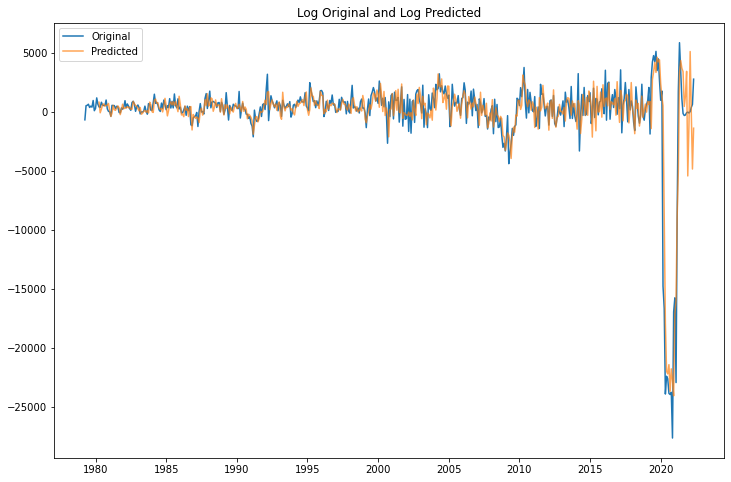

In [115]:
# Overlay our prediction over the actual data to get a sense of how good 
# the model is.

plt.figure(figsize=(12,8))

plt.title('Log Original and Log Predicted')
plt.plot(ydiff, label='Original')
plt.plot(pred, alpha=0.7, label='Predicted')

plt.legend()
plt.show()
# plt.plot(forecast)

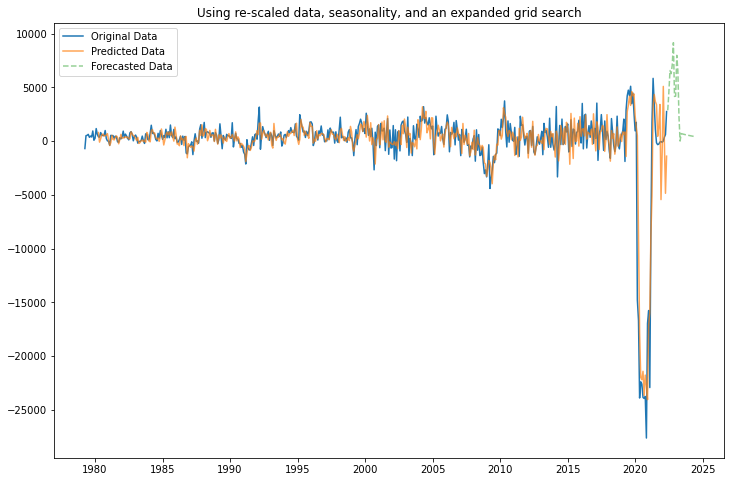

In [118]:
plt.figure(figsize=(12,8))

# plot our original data, with prediction overlay and then project the forecast
plt.title('Using re-scaled data, seasonality, and an expanded grid search')
plt.plot(ydiff, label='Original Data')
plt.plot(pred, alpha=0.7, label='Predicted Data')
plt.plot(forecast, label='Forecasted Data', alpha=0.5, ls='--')

plt.legend()
plt.show()

# 2.0 Accomodation-Data